In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder 
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.preprocessing import OneHotEncoder 

from sklearn.base import BaseEstimator, TransformerMixin

train_test_split
lb = LabelEncoder()

In [2]:
df_mat = pd.read_csv('student-mat.csv')
df_por = pd.read_csv('student-por.csv')

df = pd.concat([df_mat,df_por], ignore_index=True)

print(df['G3'].describe())
print(df['G3'])

count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64
0        6
1        6
2       10
3       15
4       10
        ..
1039    10
1040    16
1041     9
1042    10
1043    11
Name: G3, Length: 1044, dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)


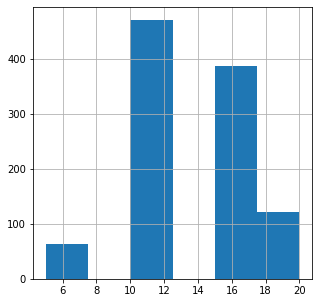

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

df["Khoảng G3"] = pd.cut(df['G3'],
                    bins=[-1,5,11,15,20, np.inf],
                    labels=[5,11,15,20,25])
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in splitter.split(df, df["Khoảng G3"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

print(df["Khoảng G3"].hist(bins=6,figsize=(5,5)))
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


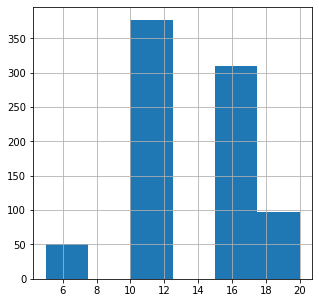

In [4]:
print(train_set["Khoảng G3"].hist(bins=6,figsize=(5,5)))
plt.show()

AxesSubplot(0.125,0.125;0.775x0.755)


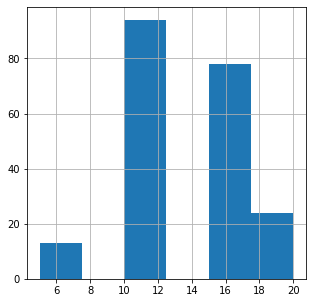

In [5]:
print(test_set["Khoảng G3"].hist(bins=6,figsize=(5,5)))
plt.show()

In [6]:
#Remove the new feature "Khoảng G3"
for _set_ in (train_set, test_set):
    _set_.drop(columns="Khoảng G3", inplace=True)

In [7]:
print(train_set.info())
print(test_set.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 835 entries, 602 to 337
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      835 non-null    object
 1   sex         835 non-null    object
 2   age         835 non-null    int64 
 3   address     835 non-null    object
 4   famsize     835 non-null    object
 5   Pstatus     835 non-null    object
 6   Medu        835 non-null    int64 
 7   Fedu        835 non-null    int64 
 8   Mjob        835 non-null    object
 9   Fjob        835 non-null    object
 10  reason      835 non-null    object
 11  guardian    835 non-null    object
 12  traveltime  835 non-null    int64 
 13  studytime   835 non-null    int64 
 14  failures    835 non-null    int64 
 15  schoolsup   835 non-null    object
 16  famsup      835 non-null    object
 17  paid        835 non-null    object
 18  activities  835 non-null    object
 19  nursery     835 non-null    object
 20  higher  

In [8]:
#Split label
train_set_label = train_set['G3'].copy()
train_set = train_set.drop(columns='G3')
test_set_label = test_set['G3'].copy()
test_set = test_set.drop(columns='G3')

In [9]:
train_set_label.loc[train_set_label[:,] < 10, ] = 0 
train_set_label.loc[train_set_label[:,] >= 10,] = 1

test_set_label.loc[test_set_label[:,] < 10, ] = 0
test_set_label.loc[test_set_label[:,] >= 10, ] = 1

In [12]:
#Convert category to numberic
def Fit_Transform(cat_array, data):
    for i in cat_array:
        data.iloc[:,i] = lb.fit_transform(data.iloc[:,i])
    return data

cat_feat_index = [0,1,2,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22]
processed_train_set_val = Fit_Transform(cat_feat_index, train_set)
processed_test_set = Fit_Transform(cat_feat_index, test_set)

In [13]:

from sklearn import tree
from sklearn.model_selection import cross_val_score

max_depths = np.linspace(1, 57, 57, endpoint=True)


test_results = []
for max_depth in max_depths:
    model = tree.DecisionTreeClassifier(criterion="entropy", max_depth=max_depth)
    dtc = model.fit(processed_train_set_val,train_set_label)
    sc = cross_val_score(dtc, processed_test_set, test_set_label, scoring='roc_auc', cv=5)
    test_results.append(sc.mean())

max_dep_value = test_results[0]
max_dep_index = 0

for i in range(0,len(test_results)):
    if(test_results[i]>max_dep_value):
        max_dep_index = i
        max_dep_value = test_results[i]

print(max_dep_index)

1


In [14]:
# Sau khi sp sánh rmse cảu Decision Tree Classification và Decision Tree Regression
# => Chọn Decision Tree Classification
model = tree.DecisionTreeClassifier(criterion="entropy", max_depth = max_dep_index+1)
dtc = model.fit(processed_train_set_val,train_set_label)
sc = cross_val_score(dtc, processed_test_set, test_set_label, scoring='roc_auc', cv=5)
print("AUC: %0.2f (+/- %0.2f)" % (sc.mean(), sc.std() * 2))

AUC: 0.97 (+/- 0.05)


In [15]:

from sklearn.metrics import classification_report
from sklearn import metrics

pd = model.predict(processed_test_set)
print(pd)

result1 = metrics.classification_report(test_set_label, pd)
print("Classification Report:",)
print (result1)

[0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79        52
           1       0.90      0.99      0.94       157

    accuracy                           0.91       209
   macro avg       0.92      0.83      0.86       209
weighted avg       0.91      0.91      0.90       209



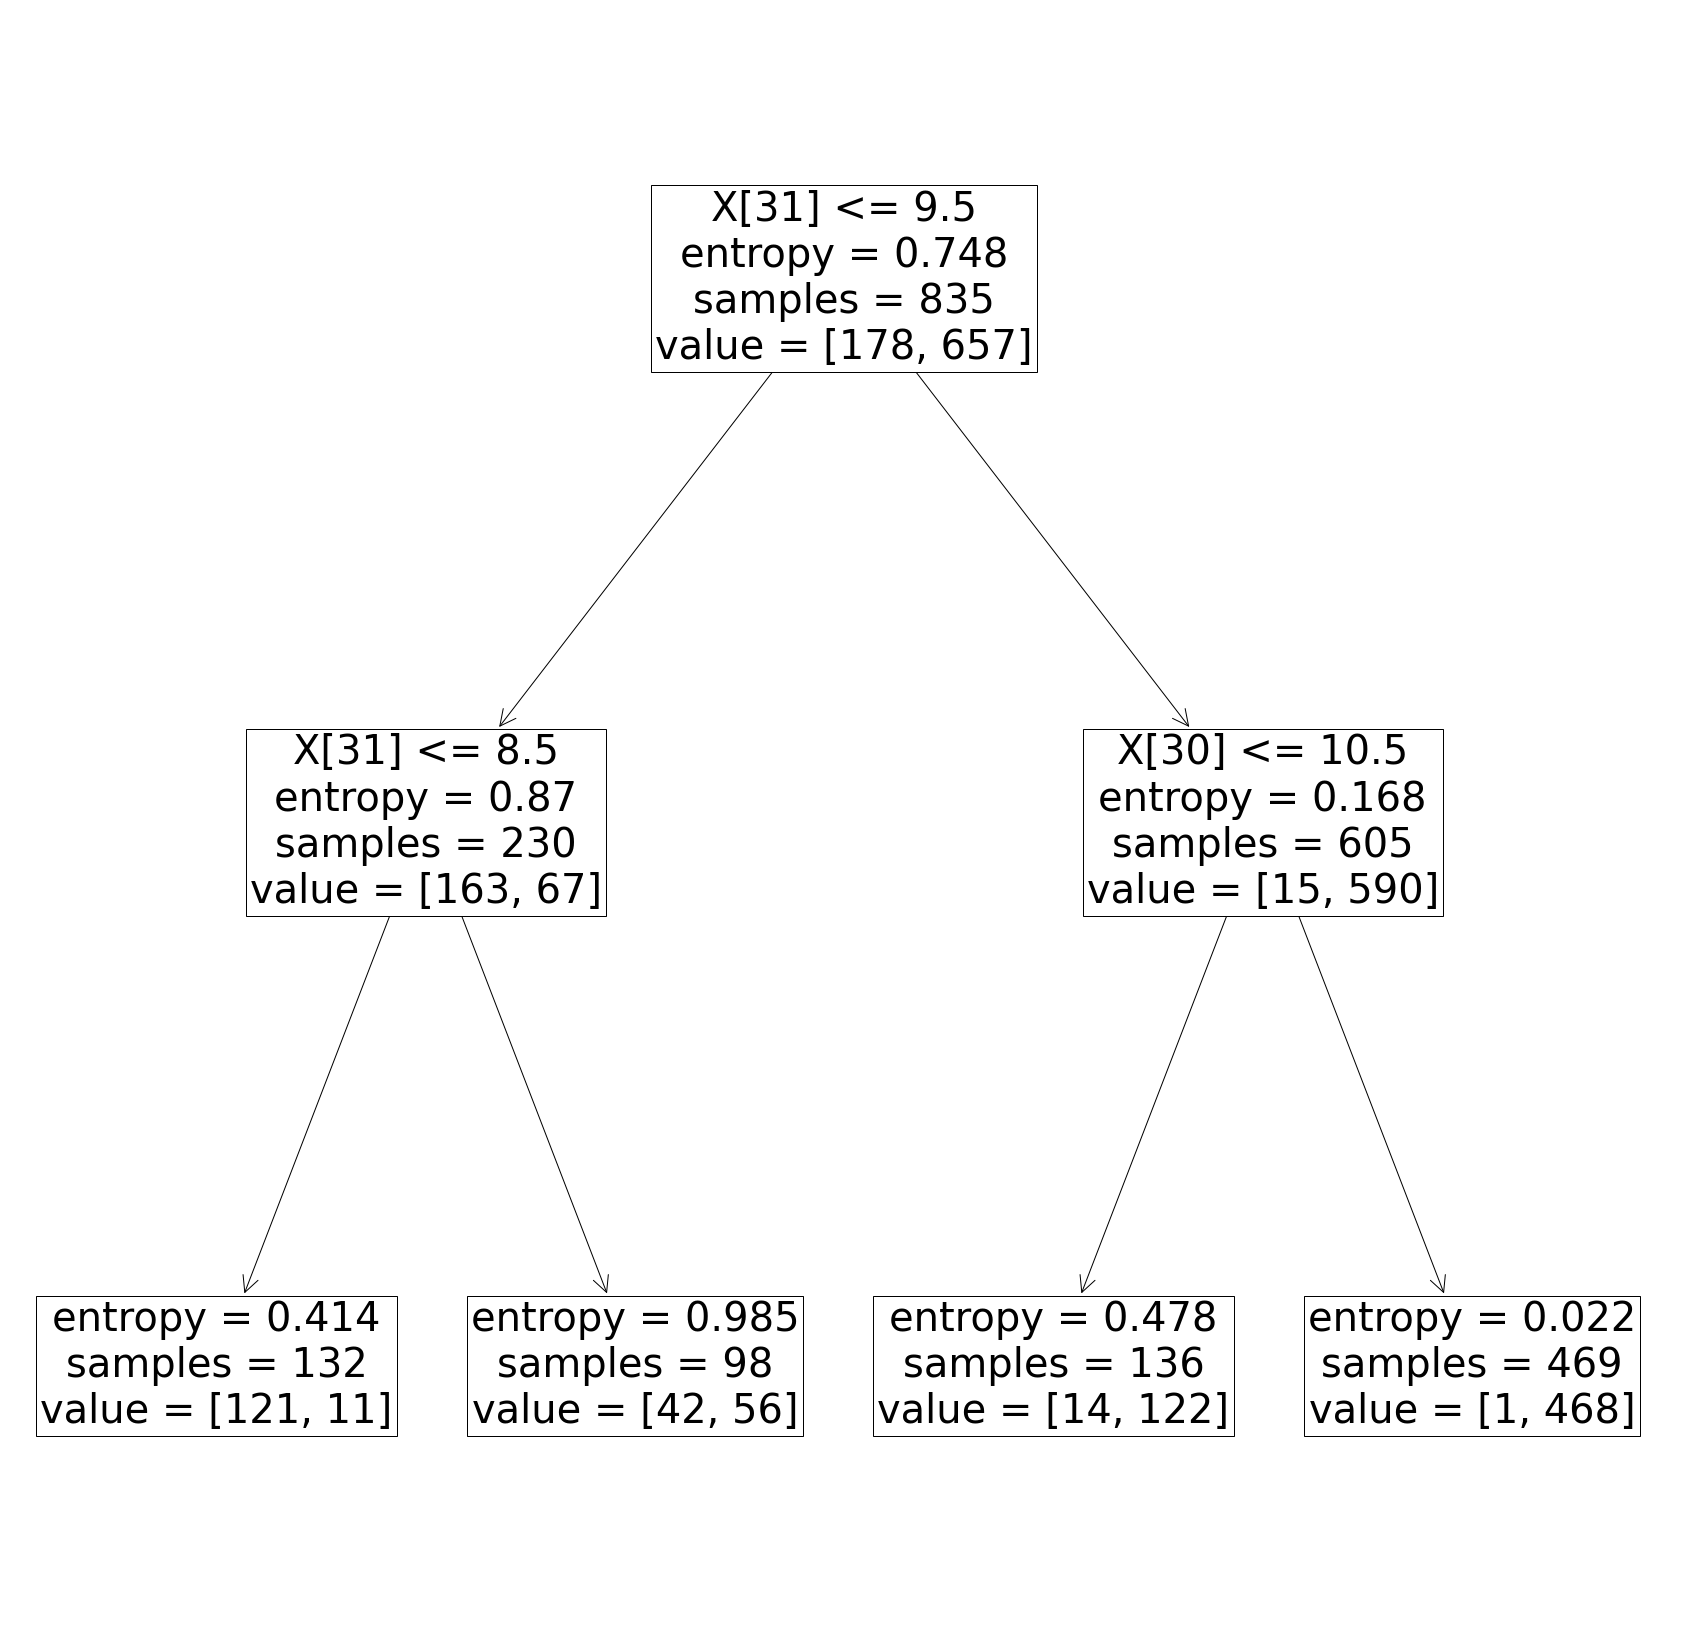

In [16]:
#xuất file vẽ sơ đồ
fig, ax = plt.subplots(figsize=(30, 30))
tree.plot_tree(model,filled=True)
plt.savefig('tree.png',format='png',bbox_inches = "tight", fontsize=40)

tree.plot_tree(model, fontsize=40)
plt.show()

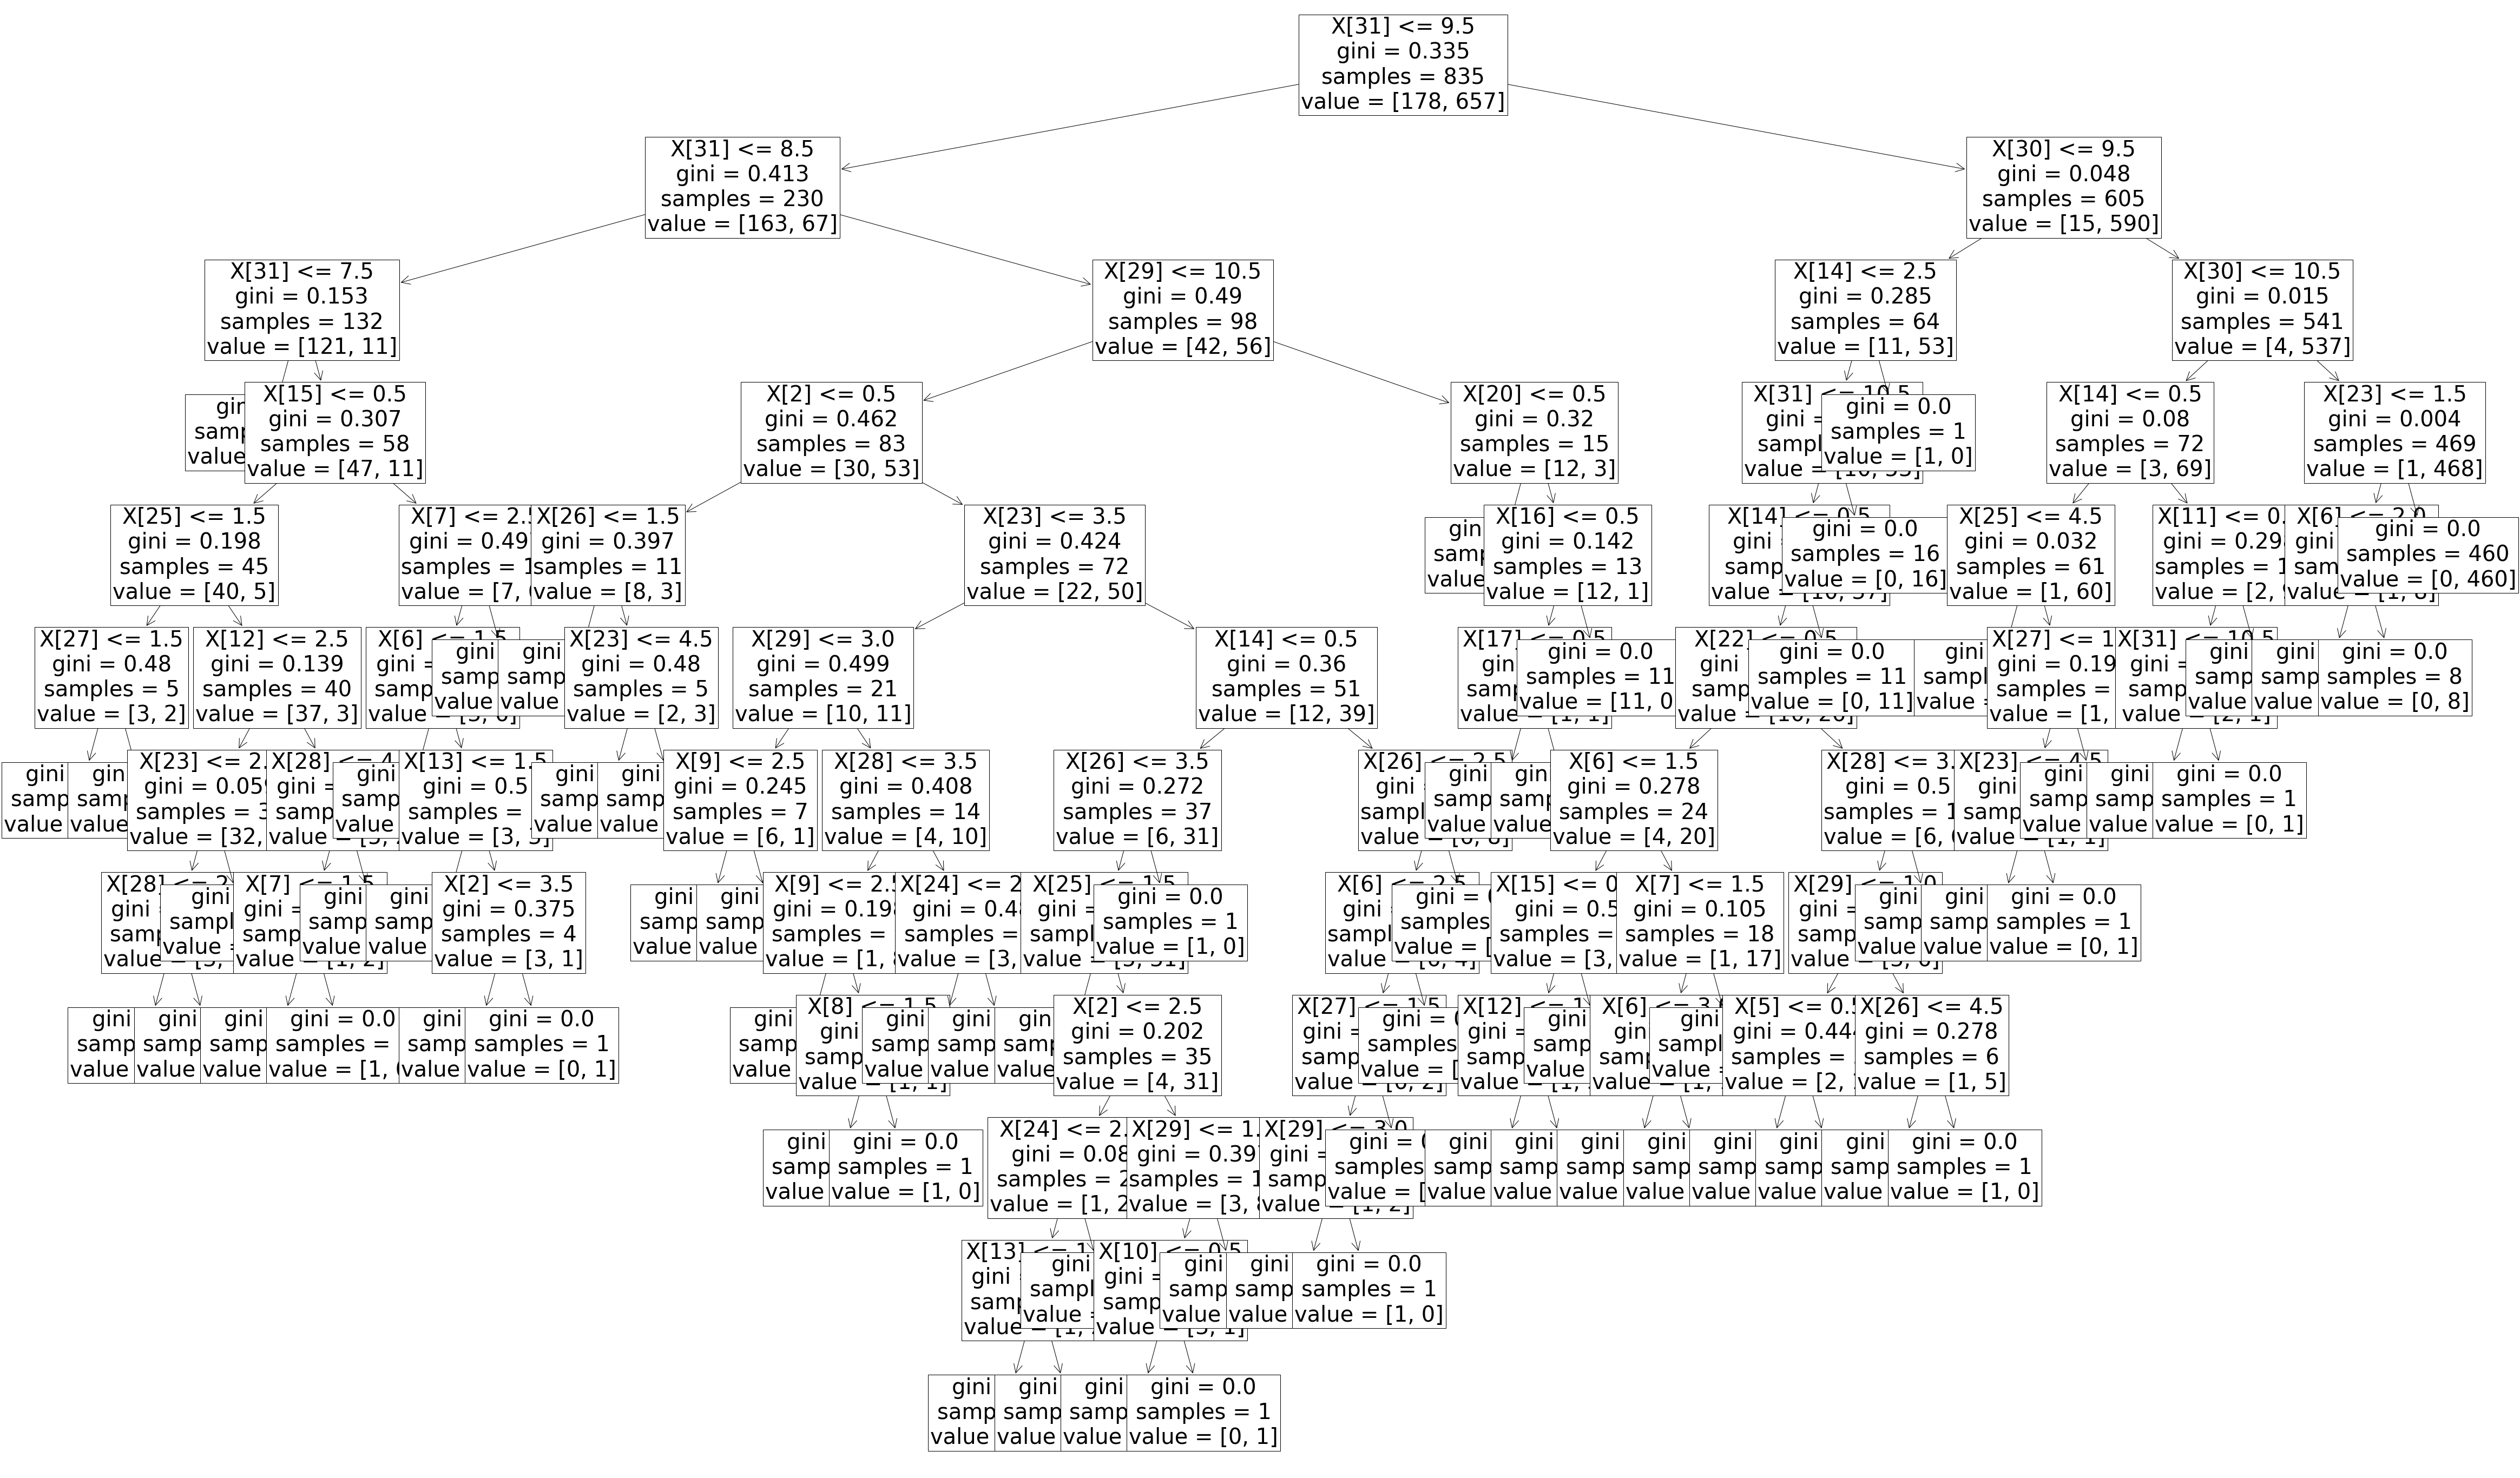

In [17]:
#xuất file vẽ sơ đồ
model = tree.DecisionTreeClassifier()
model.fit(processed_train_set_val, train_set_label)

fig, ax = plt.subplots(figsize=(80, 50))
tree.plot_tree(model,filled=True)
plt.savefig('tree_all.png',format='png',bbox_inches = "tight", fontsize=40)

tree.plot_tree(model, fontsize=40)
plt.show()